In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

from collections import Counter

import warnings

warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score

plt.rcParams['font.family'] = ['Heiti TC']

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


In [298]:
df = pd.read_csv('Graduate Admission/updated_data.csv')

In [300]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [302]:
df.head(10)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,311,107,3,2.0,2.0,9.02,0,0.719779
1,274,106,2,2.4,1.1,6.05,1,0.478592
2,331,117,1,1.3,1.4,8.93,0,0.764548
3,320,88,3,2.7,2.5,6.69,0,0.482933
4,280,94,4,1.9,3.8,6.09,1,0.579412
5,334,113,5,3.6,3.5,8.14,0,0.794644
6,334,104,2,2.6,3.7,6.14,1,0.686014
7,283,80,4,3.7,1.6,6.77,0,0.429899
8,262,90,4,3.6,2.9,8.16,1,0.650301
9,281,94,2,5.0,1.3,6.56,1,0.532007


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          2000 non-null   int64  
 1   TOEFL Score        2000 non-null   int64  
 2   University Rating  2000 non-null   int64  
 3   SOP                2000 non-null   float64
 4   LOR                2000 non-null   float64
 5   CGPA               2000 non-null   float64
 6   Research           2000 non-null   int64  
 7   Chance of Admit    2000 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 125.1 KB


In [262]:
l = df.columns
print('段名为: ', l)

段名为:  Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')


In [264]:
print(df.isnull().sum())

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64


In [266]:
from collections import Counter


def detect_outliers(df, n, features):
    """
    接受一个DataFrame（df）和特征列表，返回包含超过n个Tukey方法定义的异常值的观察索引列表。
    参数:
    df : DataFrame, 包含数据的DataFrame。
    n : int, 被认为是多异常值的最小数量。
    features : list, 需要检查异常值的特征列表。
    """
    outlier_indices = []

    # 遍历每个特征（列）
    for col in features:
        # 第一四分位数（25%）
        Q1 = np.percentile(df[col], 25)
        # 第三四分位数（75%）
        Q3 = np.percentile(df[col], 75)
        # 四分位数间距（IQR）
        IQR = Q3 - Q1

        # 异常值的步长
        outlier_step = 1.5 * IQR

        # 确定特征col的异常值索引列表
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # 将找到的异常值索引附加到异常值索引列表
        outlier_indices.extend(outlier_list_col)

    # 选择包含多于n个异常值的观察
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > n]

    return multiple_outliers


outliers_to_drop = detect_outliers(df, 2,
                                   ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research'])

# 使用该函数时需要指定DataFrame df及其它参数
# 例如：outliers_to_drop = detect_outliers(df, 2, ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research'])


因为异常值会对预测（特别是在回归问题中）产生巨大影响，所以我选择了管理这些异常值。

我使用了Tukey方法（Tukey JW., 1977）来检测异常值，该方法定义了一个介于分布值的第一四分位数和第三四分位数之间的四分位数间距（IQR）。如果某行数据在某个特征值上超出了（IQR ± 异常值步长）的范围，那么这一行就被视为含有异常值。

我决定从数值特征（GRE Score, TOEFL Score, University Rating, SOP, LOR , CGPA, Research）中检测异常值。然后，我将那些至少有两个异常数值的行视为异常值行。

In [269]:
# 显示异常值行
df.loc[outliers_to_drop]

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


不存在异常值，因为所有的值都在一个固定的范围内，没有一个值会低于或超过这个范围，因此不产生异常值

In [272]:
cols = df.drop(labels='Serial No.', axis=1)

cols.head().T

,0,1,2,3,4
GRE Score,337.00,324.00,316.00,322.00,314.00
TOEFL Score,118.00,107.00,104.00,110.00,103.00
University Rating,4.00,4.00,3.00,3.00,2.00
SOP,4.50,4.00,3.00,3.50,2.00
LOR,4.50,4.50,3.50,2.50,3.00
CGPA,9.65,8.87,8.00,8.67,8.21
Research,1.00,1.00,1.00,1.00,0.00
Chance of Admit,0.92,0.76,0.72,0.80,0.65


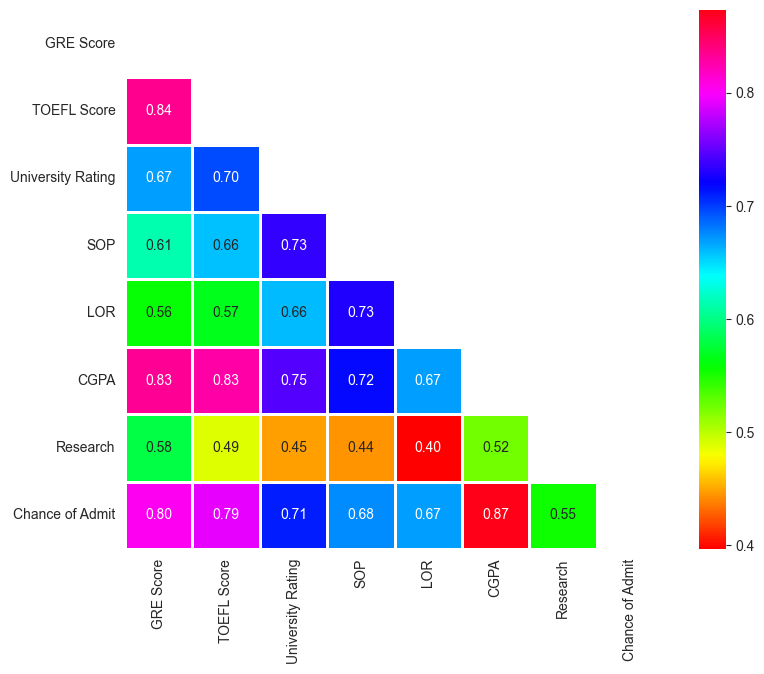

In [274]:
# 计算相关性矩阵
corr = cols.corr()

# 创建一个用于掩盖矩阵上三角的掩码
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 设置绘图风格和图像大小
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    # 绘制带掩码的热图，设置正方形格子，注释，格式化数字，线宽和颜色映射
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='0.2f', linewidths=.8, cmap="hsv")
plt.show()  # 显示图像

可以看到，录取的机会与CGPA高度相关，GRE和托福成绩也是相关的。

从上面的配对图推断:

GRE成绩、托福成绩、CGPA成绩均呈线性相关关系
无论如何，研究型学生往往得分更高

In [278]:
df.drop(columns='Serial No.', inplace=True)

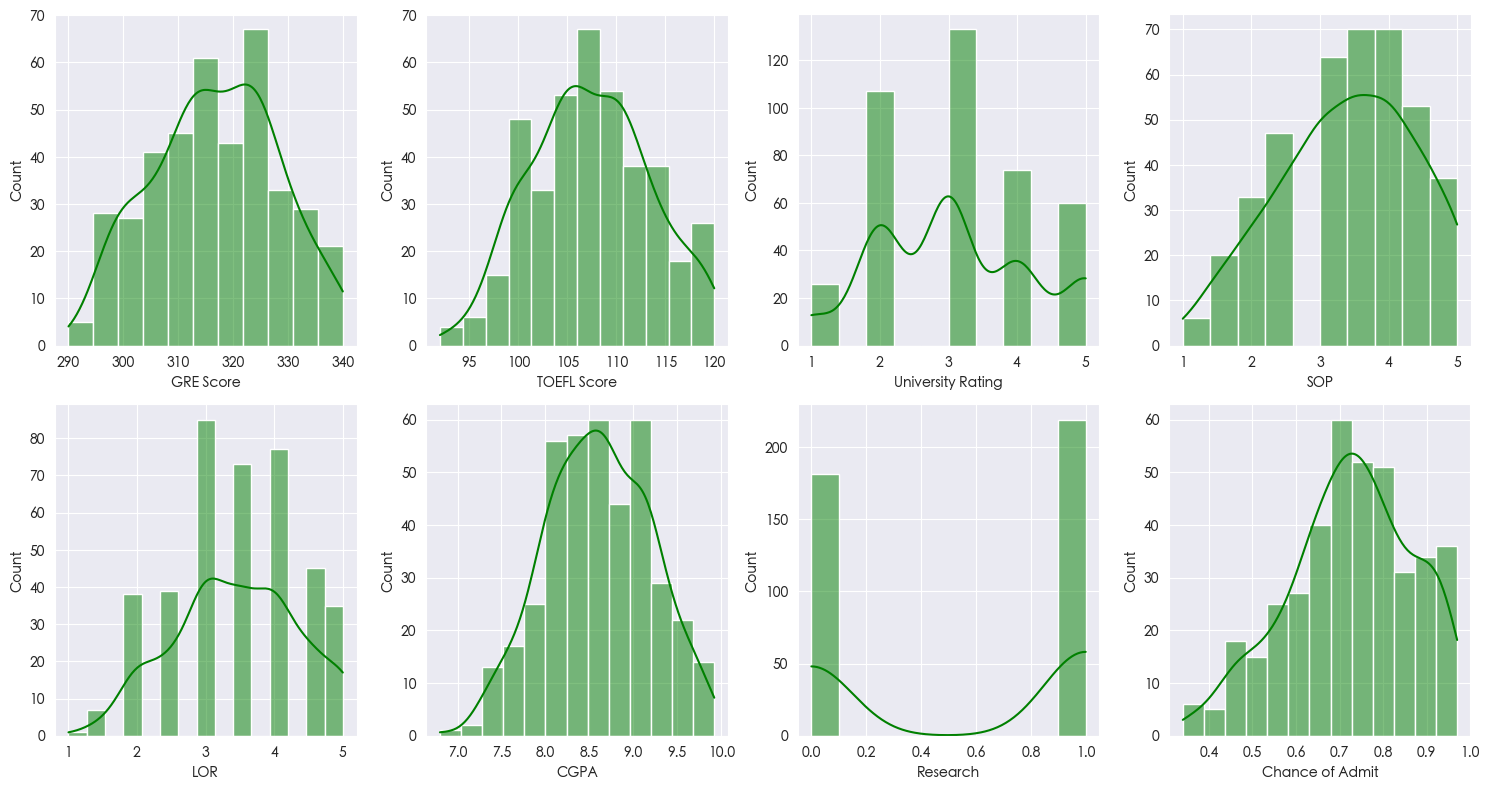

In [280]:
images_per_row = 4
plt.figure(figsize=(15, 8))

# 循环绘制每个列的分布图
for i, col in enumerate(df.columns):
    if df[col].dtype != 'object':
        plt.subplot(2, images_per_row, i + 1)
        sns.histplot(df[col], kde=True, color='green')
        plt.xlabel(col)

plt.tight_layout()
plt.show()

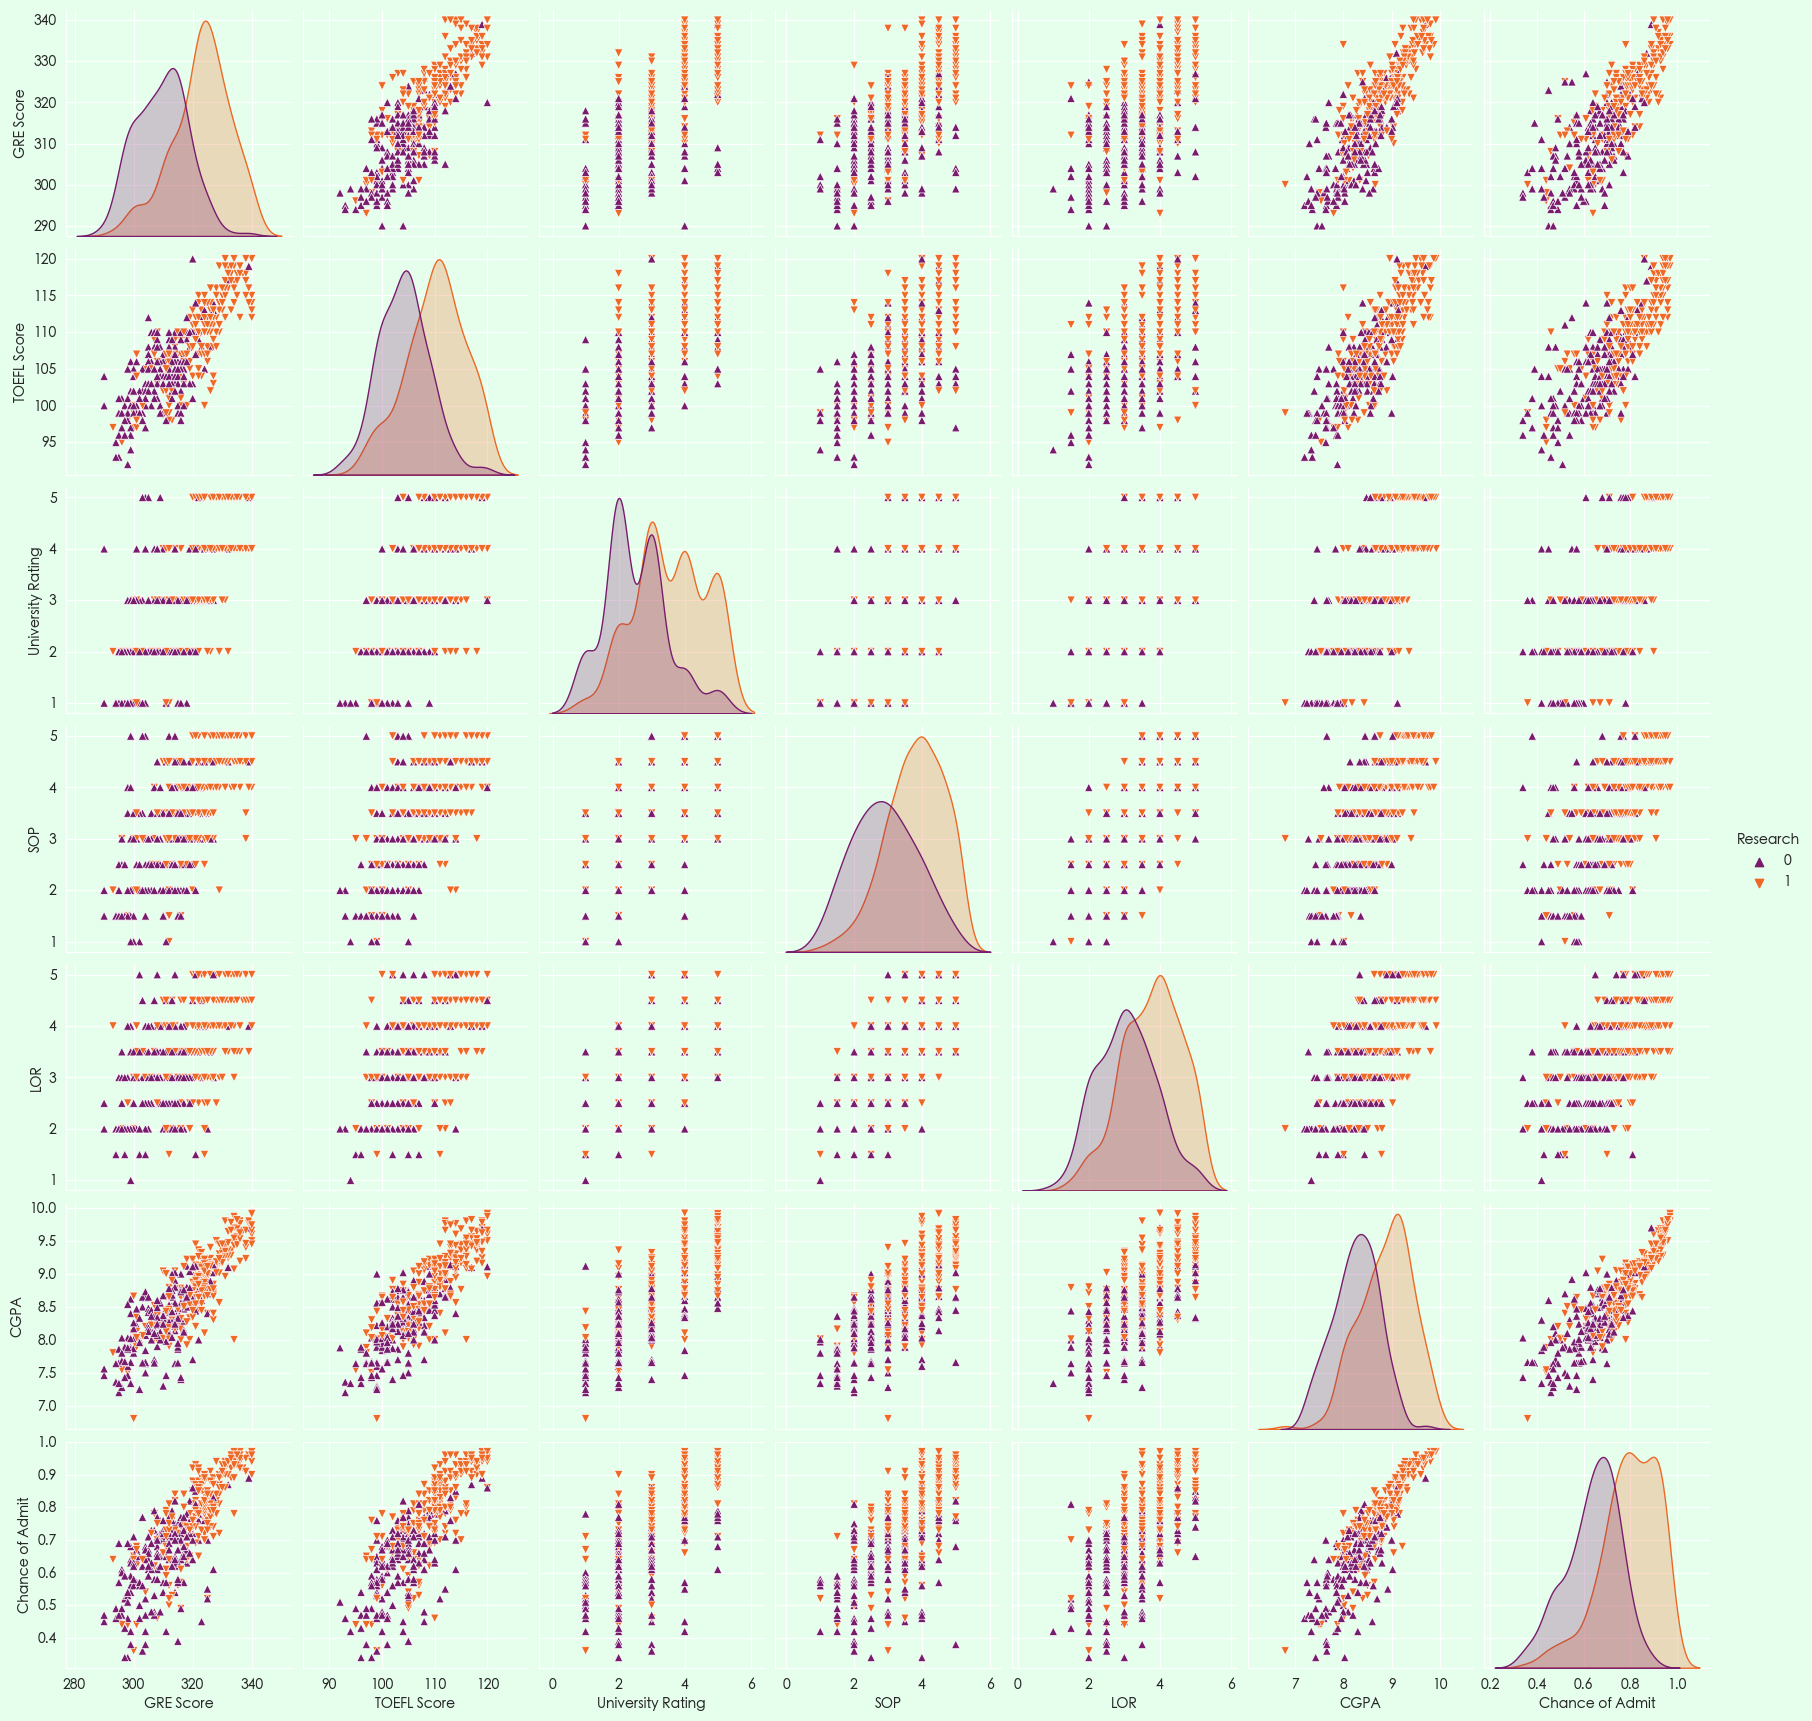

In [281]:
plt.rcParams['axes.facecolor'] = "#e6ffed"
plt.rcParams['figure.facecolor'] = "#e6ffed"
g = sns.pairplot(data=cols,hue='Research',markers=["^", "v"],palette='inferno')

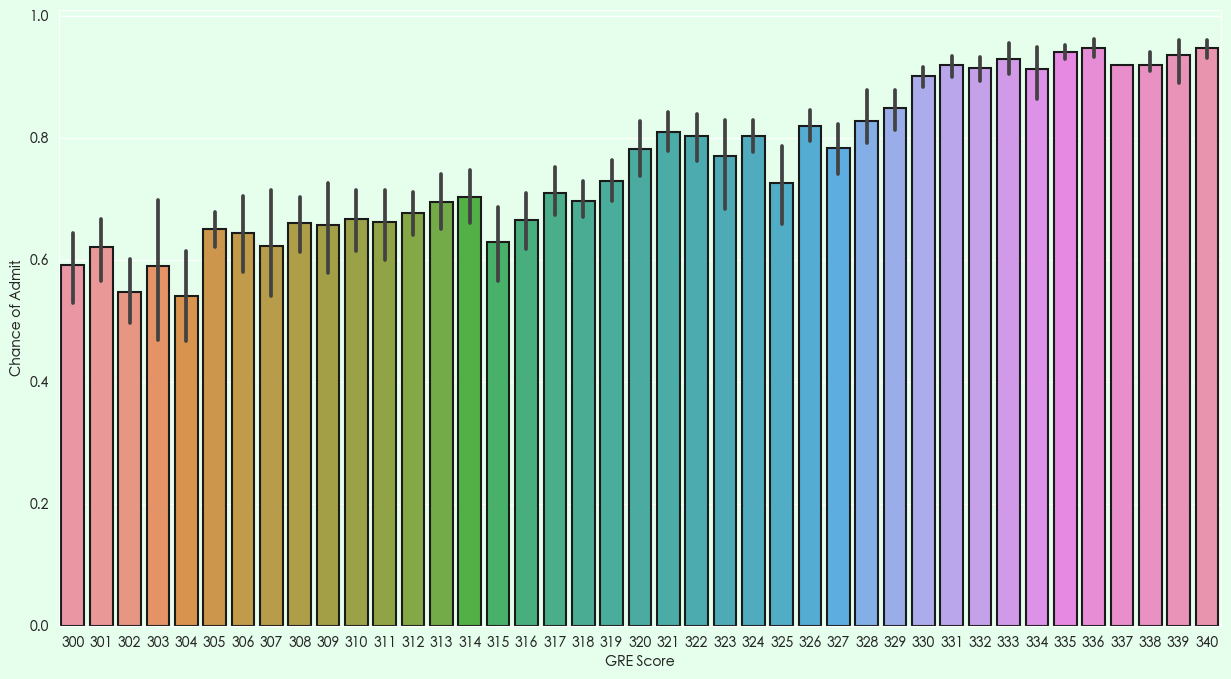

In [285]:
co_gre=df[df["GRE Score"]>=300]
co_toefel=df[df["TOEFL Score"]>=100]
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='GRE Score',y='Chance of Admit',data=co_gre, linewidth=1.5,edgecolor="0.1")
plt.show()

In [19]:
X = df.drop('Chance of Admit', axis=1)
y = df['Chance of Admit']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
3,322,110,3,3.5,2.5,8.67,1
18,318,110,3,4.0,3.0,8.80,0
202,340,120,5,4.5,4.5,9.91,1
250,320,104,3,3.0,2.5,8.57,1
274,315,100,1,2.0,2.5,7.95,0
...,...,...,...,...,...,...,...
71,336,112,5,5.0,5.0,9.76,1
106,329,111,4,4.5,4.5,9.18,1
270,306,105,2,2.5,3.0,8.22,1
348,302,99,1,2.0,2.0,7.25,0


In [22]:
# 缩放值
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
X_train

array([[0.64      , 0.64285714, 0.5       , ..., 0.375     , 0.59935897,
        1.        ],
       [0.56      , 0.64285714, 0.5       , ..., 0.5       , 0.64102564,
        0.        ],
       [1.        , 1.        , 1.        , ..., 0.875     , 0.99679487,
        1.        ],
       ...,
       [0.32      , 0.46428571, 0.25      , ..., 0.5       , 0.45512821,
        1.        ],
       [0.24      , 0.25      , 0.        , ..., 0.25      , 0.14423077,
        0.        ],
       [0.48      , 0.5       , 0.25      , ..., 0.625     , 0.46474359,
        0.        ]])

In [24]:
import pickle
# 保存模型
pickle.dump(scaler, open('models/scaler.pkl', 'wb'))

## 模型构建：神经网络架构

In [26]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [27]:
# 创建一个顺序模型对象
model = Sequential()

# 添加层到模型
# 输入层和隐藏层：
model.add(Dense(7, activation='relu', input_dim=7))
# 输出层：1个输出，使用线性激活函数，适合回归问题
model.add(Dense(1, activation='linear'))

2024-04-24 09:03:43.268039: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-24 09:03:43.268058: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-24 09:03:43.268062: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-24 09:03:43.268078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-24 09:03:43.268087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64 (256.00 B)

 Trainable params: 64 (256.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# 回归问题（损失函数 - 均方误差）
model.compile(loss='mean_squared_error', optimizer='Adam')

In [30]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10


2024-04-24 09:03:43.615612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1831 - val_loss: 0.1779
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1116 - val_loss: 0.1194
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0754 - val_loss: 0.0819
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0559 - val_loss: 0.0628
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0448 - val_loss: 0.0543
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413 - val_loss: 0.0502
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0406 - val_loss: 0.0472
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0381 - val_loss: 0.0446
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0337 - val_loss: 0.0422
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0342 - val_loss: 0.0401


In [31]:
# 获取第0层的权重和偏置
model.layers[0].get_weights()

[array([[-0.5743193 , -0.29686317,  0.2841844 , -0.17365739,  0.51908237,
          0.23377904, -0.62580293],
        [-0.0962765 , -0.43199417,  0.03669341, -0.65303624,  0.5841756 ,
         -0.20327337,  0.07607871],
        [ 0.04722098,  0.50243926, -0.24182454,  0.5329175 ,  0.3193707 ,
         -0.3932725 , -0.02826047],
        [ 0.02743426,  0.17453156,  0.59598875,  0.13883947, -0.10862743,
         -0.21520512,  0.1989438 ],
        [ 0.30837482, -0.11894801,  0.64050186,  0.5936828 ,  0.58993936,
          0.5055119 , -0.23163602],
        [ 0.4024533 , -0.45045245, -0.5346305 ,  0.22556439,  0.49080676,
         -0.16520184, -0.64337504],
        [-0.22080122,  0.5681157 , -0.53031963, -0.3278231 , -0.04432698,
          0.43604612,  0.08902597]], dtype=float32),
 array([ 0.02333448, -0.03804191,  0.0030934 , -0.02353477, -0.01561895,
         0.02027028,  0.        ], dtype=float32)]

In [32]:
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [33]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

-0.15117994818170466

R2 得分呈负数表示回归模型的性能比拟合数据的水平线差。这表明该模型无法捕获特征和目标变量之间的任何有意义的关系，从而导致预测性能较差。

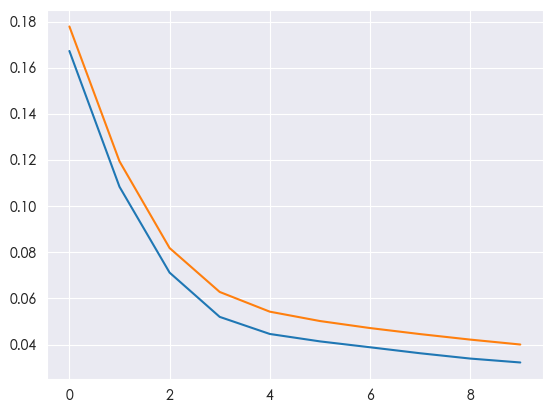

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## 模型改进

In [236]:
# 创建模型对象
model = Sequential()

# 输入层
model.add(Dense(15, activation='relu', input_dim=7))

# 隐藏层
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))

# 输出层
model.add(Dense(1, activation='linear'))

In [238]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 15)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511 (2.00 KB)

 Trainable params: 511 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

In [240]:
# 回归问题（损失函数 - 均方误差）
model.compile(loss='mean_squared_error', optimizer='Adam')

In [242]:
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4942 - val_loss: 0.4075
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3514 - val_loss: 0.2330
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1896 - val_loss: 0.1062
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0835 - val_loss: 0.0302
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0222 - val_loss: 0.0092
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0120 - val_loss: 0.0146
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - val_loss: 0.0126
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0115 - val_loss: 0.0090
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - val_loss: 0.0085
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0080
Epoch 12/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - val_lo

In [243]:
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [244]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
mean = mean_squared_error(y_test, y_pred)
r2, mean

(0.8000119169642068, 0.00516436413895063)

In [169]:
model.save('models/model.keras')

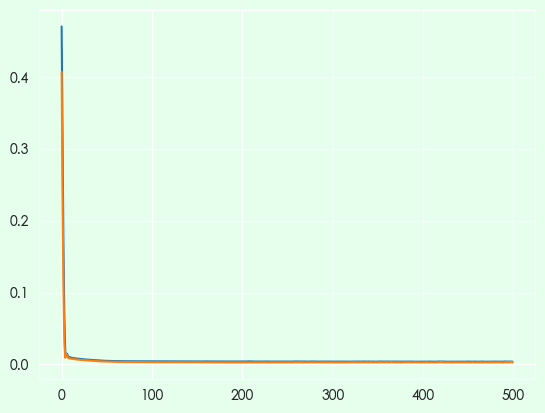

In [287]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [45]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


通过增加 epoch 数量并使用额外的隐藏层细化模型架构，R2 分数显着提高。

In [47]:
from tensorflow.keras.models import load_model

# 加载模型
loaded_model = load_model('models/model.keras')

data = pd.read_csv('Graduate Admission/Admission_Predict_Ver1.1.csv')

data = data[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']]

# 标准化数据
data_scaled = scaler.transform(data)
# 使用加载的模型进行预测
predictions = loaded_model.predict(data_scaled)

print(predictions[:10])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[0.92604357]
 [0.7850198 ]
 [0.66664726]
 [0.76438934]
 [0.6201888 ]
 [0.8957696 ]
 [0.715147  ]
 [0.6258136 ]
 [0.5413944 ]
 [0.7108512 ]]


In [48]:
from tensorflow.keras.models import load_model

model_path = 'models/model.keras'
model = load_model(model_path)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 15)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825 (11.04 KB)

 Trainable params: 941 (3.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,884 (7.36 KB)

In [49]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import SVR,SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score,mean_squared_error

In [182]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from joblib import dump

# 初始化各种模型
dtree = DecisionTreeRegressor(random_state=42)  # 决策树回归模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # 随机森林回归模型
knn = KNeighborsRegressor(n_neighbors=5)  # K-最近邻回归模型
lr = LinearRegression()  # 线性回归模型
ada = AdaBoostRegressor(random_state=42)  # AdaBoost回归模型

# 用于存储模型的字典
models = {
    "Decision Tree": dtree,
    "Random Forest": rf,
    "KNN": knn,
    "Linear Regression": lr,
    "AdaBoost": ada
}
results = {}

# 训练并评估每个模型
for name, model in models.items():
    model.fit(X_train, y_train)  # 训练模型
    predictions = model.predict(X_test)  # 对测试集进行预测
    r2 = r2_score(y_test, predictions)  # 计算 R² 分数
    mse = mean_squared_error(y_test, predictions)  # 计算均方误差
    results[name] = (r2, mse)  # 存储每个模型的评估结果
    file_path = f'models/{name.replace(" ", "_")}_model.joblib'  # 创建文件名，替换空格以防文件名错误
    dump(model, file_path)  # 使用 joblib 的 dump 函数保存模型
    print(f"{name} model saved at: {file_path}")


# 输出评估结果
for name, scores in results.items():
    print(f"{name} - R²: {scores[0]:.3f}, MSE: {scores[1]:.3f}")

Decision Tree model saved at: models/Decision_Tree_model.joblib
Random Forest model saved at: models/Random_Forest_model.joblib
KNN model saved at: models/KNN_model.joblib
Linear Regression model saved at: models/Linear_Regression_model.joblib
AdaBoost model saved at: models/AdaBoost_model.joblib
Decision Tree - R²: 0.633, MSE: 0.009
Random Forest - R²: 0.808, MSE: 0.005
KNN - R²: 0.755, MSE: 0.006
Linear Regression - R²: 0.821, MSE: 0.005
AdaBoost - R²: 0.791, MSE: 0.005


In [192]:
param_grid = {
    'n_estimators':[5,10,20,30,40,50],
    'max_depth':[2,4,6,8,10]
}
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)
print('最佳参数:{}'.format(grid.best_params_))
print('最佳交叉验证得分:{:.2f}'.format(grid.best_score_))
print('测试集得分:{:.2f}'.format(grid.score(X_test, y_test)))

最佳参数:{'max_depth': 4, 'n_estimators': 50}
最佳交叉验证得分:0.73
测试集得分:0.82
